# Signature analysis with mSigAct

First, check notebook `Selection_of_signatures_with_combinatorial_refitting.ipynb`

In [125]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from tqdm.notebook import tqdm

import matplotlib

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.transparent'] = True

## Relative to mappable genome

In [7]:
%run ../mutational_profiles/scripts/functions_genome_contexts.py

keys = list(mut_key_gen())
mut_keys = [key[0]+key[1] for key in keys]
# context_genome_dict = dict(zip(mut_keys,genome_context_counts))

cols_dict = {'Subtype':'subtype','Context':'context','Sample':'sample','Mut Depth':'mut_depth',
             'Background Count':'BackgroundCount','Mean':'mean','Lower CI':'lower_ci',
            'Upper CI':'upper_ci'}

def make_channels (row):
    mut = row['subtype']
    context = row['context']
    channel = context[0]+'['+mut+']'+context[2]
    return channel

def make_dictionary (df1,tool_format='deconstruct',context_genome_dict=None):
    
    if tool_format == 'deconstruct':        
    
        df1['channels'] = df1.apply(lambda row: make_channels(row),axis=1)
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels2'] = df1['context'] + df1['alt']
        
    elif tool_format == 'msigact':
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels'] = df1['context'] + df1['alt']
        df1['channels2'] = df1['channels']
    else:
        print('Another format?')
    
    #Make dictionary with scaled counts to the panel
    if context_genome_dict != None:   
        
        #Transform decimal values (probabilities) as counts, with the proportion of triplet occurences in the genome
        df1['counts'] = df1.apply(lambda row: int(round(row['mean']*context_genome_dict[row['channels2']],0)),axis=1)
    else:
        df1['counts'] = df1['mut_depth']        
    dictionary = dict(zip(df1['channels'],df1['counts']))
    return dictionary

In [8]:
#prepare genome ccounts to mappable genome
mappable_genome_by_chunk_dict = json.load(open('../mutational_profiles/data/hg38_1000kb_bin.filtered.mappable_positions.autosomes.trinuc_per_bin.json','rb'))
contexts = mappable_genome_by_chunk_dict['chr1:3000000-4000000'].keys()
all_contexts_dict = { context:0 for context in contexts}

for chunk in tqdm(mappable_genome_by_chunk_dict.keys()):
    contexts_dict = mappable_genome_by_chunk_dict[chunk]
    for context in contexts:
        all_contexts_dict[context] = contexts_dict[context] + all_contexts_dict[context]
        
map_genome_contexts_dict = {}
for key in keys:
    context = key[0]
    mut = key[1]
    map_genome_contexts_dict[context+mut] = all_contexts_dict[context]
map_genome_contexts_dict   

{'ACAA': 83603206,
 'ACCA': 46367544,
 'ACGA': 9335552,
 'ACTA': 67155246,
 'CCAA': 73859423,
 'CCCA': 52121678,
 'CCGA': 9622701,
 'CCTA': 71755035,
 'GCAA': 58743061,
 'GCCA': 46601530,
 'GCGA': 8245427,
 'GCTA': 56910121,
 'TCAA': 81205501,
 'TCCA': 62456262,
 'TCGA': 8043982,
 'TCTA': 92070619,
 'ACAG': 83603206,
 'ACCG': 46367544,
 'ACGG': 9335552,
 'ACTG': 67155246,
 'CCAG': 73859423,
 'CCCG': 52121678,
 'CCGG': 9622701,
 'CCTG': 71755035,
 'GCAG': 58743061,
 'GCCG': 46601530,
 'GCGG': 8245427,
 'GCTG': 56910121,
 'TCAG': 81205501,
 'TCCG': 62456262,
 'TCGG': 8043982,
 'TCTG': 92070619,
 'ACAT': 83603206,
 'ACCT': 46367544,
 'ACGT': 9335552,
 'ACTT': 67155246,
 'CCAT': 73859423,
 'CCCT': 52121678,
 'CCGT': 9622701,
 'CCTT': 71755035,
 'GCAT': 58743061,
 'GCCT': 46601530,
 'GCGT': 8245427,
 'GCTT': 56910121,
 'TCAT': 81205501,
 'TCCT': 62456262,
 'TCGT': 8043982,
 'TCTT': 92070619,
 'ATAA': 88390892,
 'ATCA': 54998890,
 'ATGA': 76404531,
 'ATTA': 106335106,
 'CTAA': 53988655,
 'CT

In [18]:
from pandas.api.types import CategoricalDtype
def create_snv_class(df):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    x = df['context']

    if x[1] in pyr:
        out = '{}{}{}{}'.format(x[0], x[1], x[2], df['alt'])
    else:
        out = '{}{}{}{}'.format(rev[x[2]], rev[x[1]], rev[x[0]], rev[df['alt']])

    return out

def context_pyr(x):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    if x[1] in pyr:
        return x
    else:
        return rev[x[2]]+rev[x[1]]+rev[x[0]]
    
def prepare_count_table(path):
    df = pd.read_csv(path,sep='\t')
    df['vaf'] = df['alt_depth'] / df['depth']
    df = df.rename(columns={'context':'context2'})
    df['context'] = df['context2'].apply(lambda x: context_pyr (x)) #transform all triplets into pyr perspective  
    
    path2 = path.replace('.mut','.genome.mut')
    df2 = pd.read_csv(path2,sep='\t')
    df2 = df2.rename(columns={'context':'context2'})
    df2['context'] = df2['context2'].apply(lambda x: context_pyr (x))  #trasnform all triplets into pyr perspective  
    df2 = df2[['context','depth']].groupby('context',as_index=False).sum() #sum all the times a triplet has been observed
    depth_dict = dict(zip(df2['context'],df2['depth']))

    df = df[(df['vaf']<0.35)&(df['variation_type']=='snv')] #filter by vaf<0.35 and snv
    df['channels'] = df.apply(create_snv_class, axis=1)

    cat_type = CategoricalDtype(categories=mut_keys, ordered=True)
    df['channels'] = df['channels'].astype(cat_type)
    df1 = df[['channels','subtype']].groupby(['channels'],as_index=False).count() #count mutations (not sum) to know number of unique muts
    df1 = df1.rename(columns={'subtype':'mut_count'})
    df1['context'] = df1['channels'].apply(lambda x: x[:-1])
    df1['subtype'] = df1['channels'].apply(lambda x: x[1]+'>'+x[3])
    df1['BackgroundCount'] = df1['context'].map(depth_dict)
    df1['mean'] = df1['mut_count'] / df1['BackgroundCount']
    return df1

## Prepare count matrix

In [11]:
sigs_dict = json.load(open('./msigact/sigs_per_sample.json','rb'))

In [12]:
sigs_dict

{'AU2198': ['SBS1', 'SBS2', 'SBS31', 'SBS45'],
 'AU2199': ['SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'],
 'AU2200': ['SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'],
 'AU2202': ['SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40'],
 'AZ4609': ['SBS5', 'SBS18', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4610': ['SBS5', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4611': ['SBS5', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4612': ['SBS1', 'SBS31', 'SBS40'],
 'AZ4613': ['SBS2', 'SBS13', 'SBS31', 'SBS40'],
 'AZ4614': ['SBS5', 'SBS18', 'SBS31', 'SBS40'],
 'AZ6342': ['SBS5', 'SBS18', 'SBS31', 'SBS40'],
 'AZ6371': ['SBS1', 'SBS18', 'SBS31', 'SBS40']}

In [123]:
print('Proportion of mappable genome triplets')
matrix_df = pd.DataFrame()
path = '../mutational_profiles/output_dnanexus/'
for file in os.listdir(path):
    if file.endswith('variant-calls.mut'):
        df1 = prepare_count_table(path+file)
        dictionary1 = make_dictionary(df1,'msigact',map_genome_contexts_dict)
        sample = file.split('.1')[0]
        if sample.startswith('CHp'):
            names_dict = {'CHp_39_T0':'AZ6342','CHp_38_T0':'AZ6371'}
            sample = names_dict[sample]
        df1 = pd.DataFrame.from_dict(dictionary1,orient='index',columns=[sample])
        df1 = df1.T
        matrix_df = pd.concat([matrix_df,df1])
matrix_df.sort_index(inplace=True)
matrix_df = matrix_df.T
selected_samples = sigs_dict.keys()
matrix_df = matrix_df[selected_samples]
matrix_df

Proportion of mappable genome triplets


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,AU2198,AU2199,AU2200,AU2202,AZ4609,AZ4610,AZ4611,AZ4612,AZ4613,AZ4614,AZ6342,AZ6371
ACAA,8,33,6,4,19,20,12,32,10,11,5,0
ACCA,11,11,2,3,21,20,11,0,0,9,4,3
ACGA,9,24,16,4,5,5,6,0,13,6,3,2
ACTA,0,5,16,2,30,14,9,6,10,10,6,0
CCAA,18,47,10,1,17,9,13,12,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
GTTG,0,0,2,1,3,4,0,12,5,2,2,0
TTAG,0,0,2,1,4,7,2,7,0,2,0,0
TTCG,0,0,4,1,12,2,3,6,9,2,1,0
TTGG,0,0,4,0,5,4,0,12,0,0,0,0


Text(0.5, 1.0, 'Mappable genome scaled\nre-calculated counts from mut file')

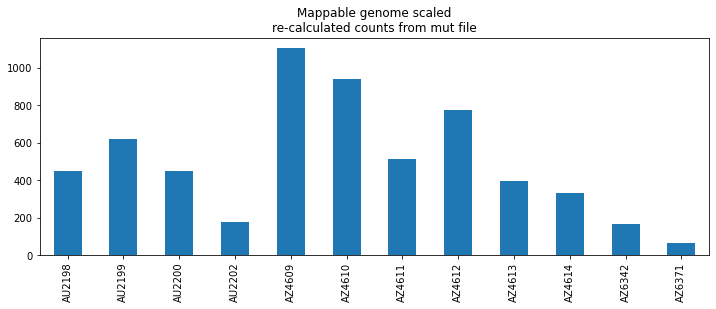

In [126]:
matrix_df.sum().plot(kind='bar',figsize=(12,4))
plt.title('Mappable genome scaled\nre-calculated counts from mut file')

In [127]:
#save matrix per sample in each folder
path = './msigact/'

for sample in matrix_df.columns:
    if not os.path.exists(path+sample):
        os.mkdir(path+sample)
    matrix_df[sample].to_csv(path+sample+'/count_matrix.tsv',sep='\t')

The code is executed with qmaps.  
Check this notebook: `./qmap_msigact.ipynb`

## Results

In [128]:
path = './msigact/'

folders = [folder for folder in os.listdir(path)if folder.startswith('A')]

SBS31_pvals = {}
SBS35_pvals = {}
SBS31_df = pd.DataFrame()
SBS35_df = pd.DataFrame()
for sample in folders:
    df = pd.read_csv(path+sample+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv',sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    df['sample_id'] = [sample]
    
    df['pval'] = df['pval'].round(4)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS31_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df[['sample_id']+sigs_cols]
    df = df.set_index('sample_id')
    SBS31_df = pd.concat([SBS31_df,df])
    
    df = pd.read_csv(path+sample+'/SBS35/results.count_matrix.tsv.mSigAct.SBS35.tsv',sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    df['sample_id'] = [sample]
    df['pval'] = df['pval'].round(5)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS35_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df.set_index('sample_id')
    SBS35_df = pd.concat([SBS35_df,df])
# SBS31_df = SBS31_df.reindex(samples_id)
# SBS35_df = SBS35_df.reindex(samples_id)
SBS31_df.fillna(0,inplace=True)
SBS31_df = SBS31_df[['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS31']]
SBS35_df.fillna(0,inplace=True)
SBS35_df = SBS35_df[['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS35']]

In [129]:
SBS31_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
sample_id,,,,,,,,
AU2198,24.976048,22.018771,0.000000,0.0,0.000000,0.000000,131.877055,269.128127
AU2199,0.000000,53.814437,0.000000,0.0,530.139260,0.000000,0.000000,35.046304
AU2200,13.903467,12.384124,207.714362,0.0,99.875719,0.000000,78.823444,34.298884
AU2202,12.410012,0.000000,0.000000,0.0,42.862809,102.964656,0.000000,18.762523
AZ4609,0.000000,0.000000,263.598884,0.0,235.830685,422.591756,0.000000,183.978674
AZ4610,0.000000,0.000000,238.573374,0.0,0.000000,346.897460,119.276185,237.252982
AZ4611,0.000000,0.000000,198.328457,0.0,0.000000,144.365381,70.154947,100.151215
AZ4612,28.012395,0.000000,0.000000,0.0,0.000000,641.733676,0.000000,106.253928
AZ4613,0.000000,18.440010,0.000000,0.0,0.000000,262.810710,0.000000,116.749280


In [130]:
def color_sigs (sigs):

    colors_dict = {}
    colors_list = []
    greys = ['gainsboro','darkgrey','gray','lightgrey','lightgray','silver','dimgrey','dimgray','slategrey']
    i = 0
    for sig in sigs:
        if 'potential' in sig:
            color = greys[i]
            i+=1
        elif 'SBS1-' in sig or sig=='SBS1':
            color = 'orange'
        elif 'SBS2-' in sig or sig=='SBS2':
            color = 'olive'
        elif 'SBS3-' in sig or sig=='SBS3':
            color = 'mediumpurple'
        elif 'SBS5-' in sig or sig=='SBS5':
            color = 'skyblue'
        elif 'SBS7a' in sig:
            color = 'teal'
        elif 'SBS12' in sig:
            color = 'seagreen'
        elif 'SBS13' in sig:
            color = 'purple'
        elif 'SBS17b' in sig:
            color = 'pink'
        elif 'SBS18' in sig:
            color = 'royalblue'
        elif 'SBS31' in sig:
            color = 'firebrick'
        elif 'SBS32' in sig:
            color = 'plum'
        elif 'SBS35' in sig:
            color = 'lightcoral'
        elif 'SBS40' in sig:
            color = 'turquoise'
#         elif 'SBS45' in sig:
#             color = 'lightgrey'
        elif 'SBS60' in sig:
            color = 'darkseagreen'
        else:
            color = greys[i]
            i+=1
            pass
        colors_dict[sig] = color
        colors_list.append(color)
    return colors_dict,colors_list

def plot_fitting_with_pval2 (df,title,sigs,labels,ylim,figsize):
    
    colors_dict,colors_list = color_sigs(sigs)
    
    #make plot
    df.plot(kind='bar', stacked=True, figsize=figsize,color=colors_list,edgecolor='white')
    plt.grid(False)
    
    plt.title(title,size=20,pad=20)
    

    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 14})
    
    plt.tick_params(left = False,bottom=False)
    #y-axis
    plt.ylabel('Number of mutations',size=18)
    plt.ylim(0,ylim)
    
    #x-axis
    plt.xlabel('')
    ticks = range(0,len(df))
    plt.xticks(ticks, labels, rotation=0,size=16,ha='center')

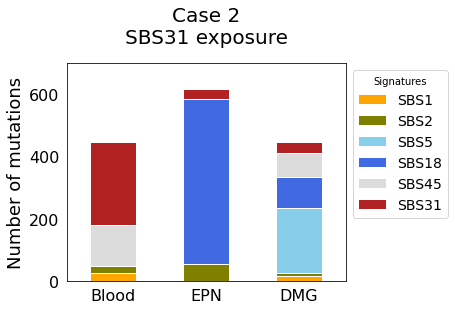

In [131]:
selected_samples = ['AU2198','AU2199','AU2200']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood','EPN','DMG']
title = 'Case 2\nSBS31 exposure'
ylim=700
figsize = (5,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,800,200),size=16)
plt.savefig('./figures_paper/case2_sbs31_relative_exposures.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()


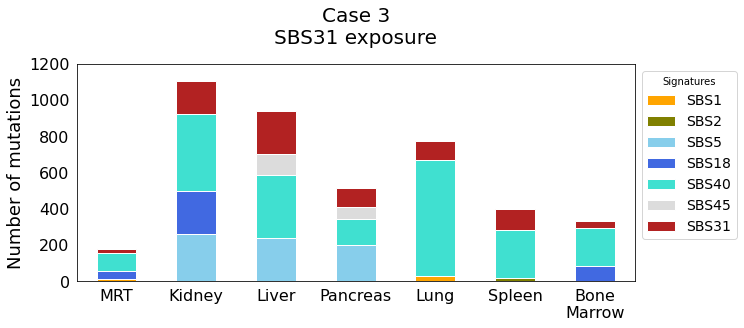

In [132]:
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['MRT', 'Kidney','Liver','Pancreas','Lung','Spleen','Bone\nMarrow']
title = 'Case 3\nSBS31 exposure'
ylim=1200
figsize = (10,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,1300,200),size=16)
plt.savefig('./figures_paper/case3_sbs31_relative_exposures.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


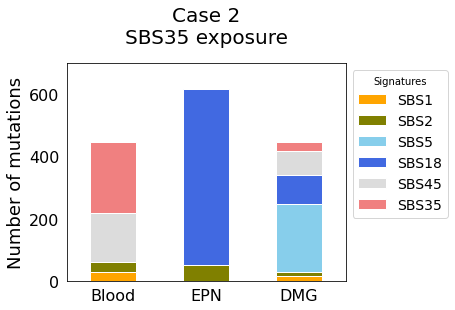

In [135]:
selected_samples = ['AU2198','AU2199','AU2200']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood', 'EPN','DMG']
title =  'Case 2\nSBS35 exposure'
ylim=700
figsize = (5,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,800,200),size=16)
plt.savefig('./figures_paper/case2_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')



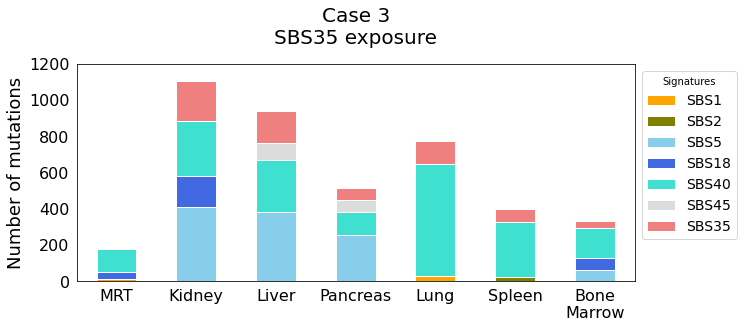

In [136]:
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['MRT', 'Kidney','Liver','Pancreas','Lung','Spleen','Bone\nMarrow']
title = 'Case 3\nSBS35 exposure'
ylim=1200
figsize = (10,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,1300,200),size=16)
plt.savefig('./figures_paper/case3_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

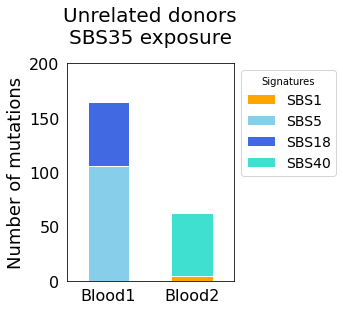

In [141]:
selected_samples = ['AZ6342','AZ6371']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood1', 'Blood2']
title =  'Unrelated donors\nSBS35 exposure'
ylim=200
figsize = (3,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,210,50),size=16)
plt.savefig('./figures_paper/NonTreatedBloods_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


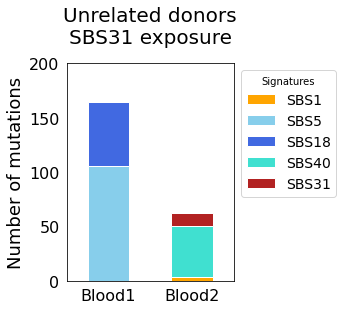

In [142]:
selected_samples = ['AZ6342','AZ6371']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood1', 'Blood2']
title =  'Unrelated donors\nSBS31 exposure'
ylim=200
figsize = (3,4)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,210,50),size=16)
plt.savefig('./figures_paper/NonTreatedBloods_sbs31_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


## Plots with confidence intervals
The confidence intervals are calculated in ```./test_sbs31_specificity_and_cnofidence_intervals.ipynb```.\
First execute that notebook, then come back here and continue.

In [180]:
file = './confidence_intervals/ci_sbs31.json'
ci_sbs31_dict = json.load(open(file,'rb'))
file = './confidence_intervals/ci_aging.json'
ci_aging_dict = json.load(open(file,'rb'))

In [181]:
ci_aging_dict

{'AU2198': [22, 28],
 'AU2199': [0, 0],
 'AU2200': [208, 235],
 'AU2202': [96, 125],
 'AZ4609': [630, 741],
 'AZ4610': [530, 638],
 'AZ4611': [309, 376],
 'AZ4612': [606, 716],
 'AZ4613': [227, 302],
 'AZ4614': [195, 224],
 'AZ6342': [86, 105],
 'AZ6371': [37, 57]}

In [134]:
import matplotlib.lines as mlines

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


sbs31 ci:
[24.128126739429035, 20.0463036273185, 24.2988839904179]
[20.871873260570965, 24.9536963726815, 25.7011160095821]
aging ci:
[2.976047539675303, 0.0, 13.617829394681337]
[3.023952460324697, 0.0, 13.382170605318663]


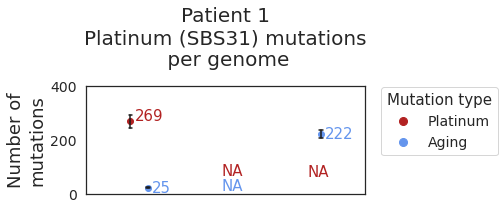

In [218]:
selected_samples = ['AU2198','AU2199','AU2200']
aging_sigs = ['SBS1','SBS5','SBS40']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df['aging_sigs'] = df[aging_sigs].sum(axis=1)
df = df[['SBS31','aging_sigs']]
sigs = df.columns.tolist()
labels = []
title = 'Patient 1\nPlatinum (SBS31) mutations\n per genome'
ylim=400
xlabel=''
ylabel='Number of\nmutations'
loc=-80
legend=False
figsize = (5,2)
rotation_xtick=0
rotation_pvals=0
ha='center'

ci_low = [ df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0] for s in selected_samples]
ci_high = [ ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0] for s in selected_samples]
print('sbs31 ci:')
print(ci_low)
print(ci_high)

horizontal_line_width = 0.04
plt.figure(figsize=figsize)
for x,val in enumerate(df['SBS31'].tolist()):
    if x in [1,2]:
        pass
    else:
        pos = x
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='firebrick')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
    
ci_low = [ df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0] for s in selected_samples]
ci_high = [ ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0] for s in selected_samples]
print('aging ci:')
print(ci_low)
print(ci_high)

for x,val in enumerate(df['aging_sigs'].tolist()):
    if x in [1]:
        pass
    else:
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='cornflowerblue')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

#df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
plt.title(title,size=20,pad=20)
plt.margins(0.22,0)

#y-axis
plt.ylabel(ylabel)
plt.ylim(0,ylim)

#x-axis
plt.xlabel(xlabel)
ticks = range(0,len(df))
plt.xticks(ticks,[])
plt.yticks(np.arange(0, ylim+100, 200),size=14)

for i, v in enumerate(df['SBS31']):
    if i in [1,2]:
        plt.text(i+0.05, v+50, 'NA', color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    else:
        plt.text(i+0.05, v+20, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
for i, v in enumerate(df['aging_sigs']):
    if i in [1]:
        plt.text(i+0.05, v+30, 'NA', color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)        
    else:
        plt.text(i+0.25, v-0, str(int(round(v,0))), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)

sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                          markersize=8, label='Platinum')
aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                          markersize=8, label='Aging')
plt.legend(handles=[sbs31,aging],bbox_to_anchor=(0.5,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)
ax.grid(False)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/pt1_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()

In [405]:
def small_plot (selected_sample,figsize=(1,2),ylim=400):
    print(selected_sample)
    s = selected_sample[0]
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = SBS31_df[SBS31_df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df = df[['SBS31','aging_sigs']]
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Number of\nmutations'
    loc=-80
    legend=False

    rotation_xtick=0
    rotation_pvals=0
    ha='center'

    ci_low = [ df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0] for s in selected_sample]
    ci_high = [ ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0] for s in selected_sample]

    horizontal_line_width = 0.04

    fig, ax = plt.subplots(figsize=figsize)

    for x,val in enumerate(df['SBS31'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, 'o',color='white',markersize=10)
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.plot(pos, val, 'o',color='firebrick',markersize=10)
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = [ df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0] for s in selected_sample]
    ci_high = [ ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0] for s in selected_sample]

    for x,val in enumerate(df['aging_sigs'].tolist()):
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.plot(pos, val, 'o',color='cornflowerblue',markersize=10)
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    #df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
    plt.title(title,size=20,pad=20)
    plt.margins(0.22,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
    plt.yticks(np.arange(0, ylim+100, 200),size=14)

    for i, v in enumerate(df['SBS31']):
        if s in ['AZ6342','AZ6371']:
            pass
        else:
            plt.text(i+0.05, v+20, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    for i, v in enumerate(df['aging_sigs']):
        plt.text(i+0.25, v-0, str(int(round(v,0))), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)

    sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                              markersize=8, label='Platinum')
    aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                              markersize=8, label='Aging')
    # plt.legend(handles=[sbs31,aging],bbox_to_anchor=(1,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)


    ax.grid(False)
    plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/'+selected_sample[0]+'_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
    plt.show()

['AU2198']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


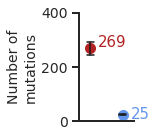

['AZ4609']


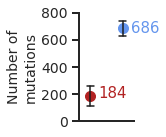

['AZ4610']


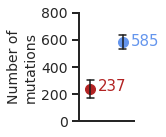

['AZ4611']


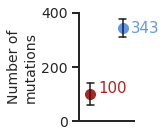

['AZ4612']


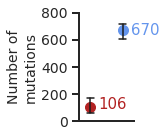

['AZ4613']


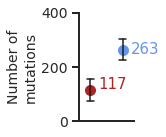

['AZ4614']


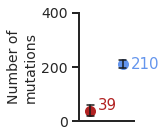

['AZ6342']


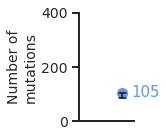

['AZ6371']


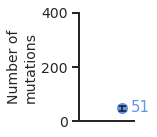

In [406]:
selected_sample = ['AU2198']
small_plot(selected_sample)
selected_sample = ['AZ4609']
small_plot(selected_sample,ylim=800)
selected_sample = ['AZ4610']
small_plot(selected_sample,ylim=800)
selected_sample = ['AZ4611']
small_plot(selected_sample,ylim=400)
selected_sample = ['AZ4612']
small_plot(selected_sample,ylim=800)
selected_sample = ['AZ4613']
small_plot(selected_sample,ylim=400)
selected_sample = ['AZ4614']
small_plot(selected_sample,ylim=400)
selected_sample = ['AZ6342']
small_plot(selected_sample,ylim=400)
selected_sample = ['AZ6371']
small_plot(selected_sample,ylim=400)

In [606]:
def small_barplot (selected_sample,figsize=(1,2),ylim=400,x_val1=150,x_val2=150,range_val=200):
    print(selected_sample)
    s = selected_sample[0]
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = SBS31_df[SBS31_df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df = df[['SBS31','aging_sigs']]
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Number of\nmutations'
    loc=-80
    legend=False

    rotation_xtick=0
    rotation_pvals=0
    ha='center'

    ci_low = [ df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0] for s in selected_sample]
    ci_high = [ ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0] for s in selected_sample]

    horizontal_line_width = 0.04

    fig, ax = plt.subplots(figsize=figsize)

    for x,val in enumerate(df['SBS31'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, 'o',color='white',markersize=10)
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.bar(pos, val, color='firebrick',width=0.1,edgecolor='firebrick')
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = [ df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0] for s in selected_sample]
    ci_high = [ ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0] for s in selected_sample]

    for x,val in enumerate(df['aging_sigs'].tolist()):
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.bar(pos, val, color='cornflowerblue',width=0.1,edgecolor='cornflowerblue')
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    #df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
    plt.title(title,size=20,pad=20)
    plt.margins(0.22,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
    plt.yticks(np.arange(0, ylim+100, range_val),size=14)

    for i, v in enumerate(df['SBS31']):
        if s in ['AZ6342','AZ6371']:
            plt.text(i+0.04, x_val1, str(0), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
        else:
            plt.text(i+0.02, v+x_val1, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
    
    for i, v in enumerate(df['aging_sigs']):
        plt.text(i+0.2, v+x_val2, str(int(round(v,0))), color='cornflowerblue', fontweight='normal',ha='center',va='center',size=15)

#     sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
#                               markersize=8, label='Platinum')
#     aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
#                               markersize=8, label='Aging')
    # plt.legend(handles=[sbs31,aging],bbox_to_anchor=(1,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)


    ax.grid(False)
    plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/'+selected_sample[0]+'_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
    plt.show()

['AU2198']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


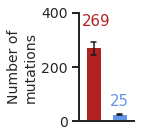

['AZ4609']


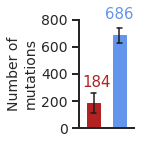

['AZ4610']


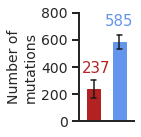

['AZ4611']


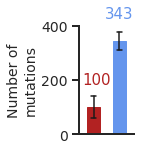

['AZ4612']


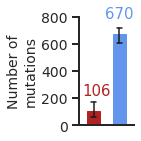

['AZ4613']


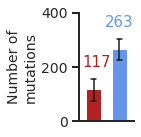

['AZ4614']


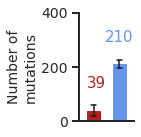

['AZ6342']


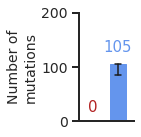

['AZ6371']


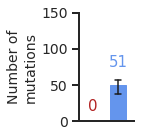

In [610]:
selected_sample = ['AU2198']
small_barplot(selected_sample,ylim=400,x_val1=100,x_val2=50)
selected_sample = ['AZ4609']
small_barplot(selected_sample,ylim=800)
selected_sample = ['AZ4610']
small_barplot(selected_sample,ylim=800)
selected_sample = ['AZ4611']
small_barplot(selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ4612']
small_barplot(selected_sample,ylim=800)
selected_sample = ['AZ4613']
small_barplot(selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ4614']
small_barplot(selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ6342']
small_barplot(selected_sample,ylim=200,x_val1=25,x_val2=30,range_val=100)
selected_sample = ['AZ6371']
small_barplot(selected_sample,ylim=100,x_val1=20,x_val2=30,range_val=50)

['AU2202']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


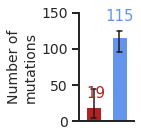

In [615]:
selected_sample = ['AU2202']
small_barplot(selected_sample,ylim=100,x_val1=20,x_val2=30,range_val=50)

In [632]:
SBS31_df[['SBS1','SBS5','SBS18','SBS40']][SBS31_df.index=='AU2202'].sum(axis=1)

sample_id
AU2202    158.237477
dtype: float64

In [650]:
import matplotlib as mpl
import matplotlib.lines as mlines

In [678]:
def plot_2_bars (df,sample_id,title,ylim,y_val1,y_val2,xlabel,ylabel):
    df1 = df[df.index.isin([sample_id])]

    other_sigs = ['SBS1','SBS5','SBS18','SBS40']

    df1['other_sigs'] = df1[other_sigs].sum(axis=1)
    df1 = df1[['SBS31','other_sigs']]

    figsize = (2,2)

    fig, ax = plt.subplots(figsize=figsize)

    for x,val in enumerate(df1['SBS31'].tolist()):
        if sample_id in ['AU2202']:          
            pos = x-0.2
            ax.bar(pos, 0,color='firebrick',width=0.2)
        else:
            pos = x-0.2
            ax.bar(pos, val,color='firebrick',width=0.2)            


    for x,val in enumerate(df1['other_sigs'].tolist()):
        pos = x +0.2
        ax.bar(pos, val,color='grey',width=0.2)

    plt.xticks([])
    plt.xlabel(xlabel,size=14)
    plt.title(title,size=20,pad=20)
    plt.ylim(0,ylim)
    plt.ylabel(ylabel,size=14)
    plt.yticks(size=12)

    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    
    for i, v in enumerate(df1['SBS31']):
        if sample_id in ['AU2202']:
            plt.text(i-0.2, v+y_val1, '0', color='firebrick', fontweight='normal',ha='center',va='center',size=15)
        else:
            plt.text(i-0.2, v+y_val1, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
            
        for i, v in enumerate(df1['other_sigs']):
            plt.text(i+0.2, v+y_val2, str(int(round(v,0))), color='grey', fontweight='normal',ha='center',va='center',size=15)


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


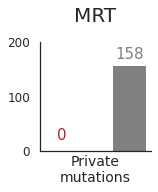

In [679]:
sample_id = 'AU2202'
y_val1 = 10
y_val2 = 20
title = 'MRT'
xlabel = 'Private\nmutations'
ylabel = ''
plot_2_bars (SBS31_df,sample_id,title,ylim,y_val1,y_val2,xlabel,ylabel)

In [690]:
SBS31_df.sum(axis=1)

sample_id
AU2198     448.0
AU2199     619.0
AU2200     447.0
AU2202     177.0
AZ4609    1106.0
AZ4610     942.0
AZ4611     513.0
AZ4612     776.0
AZ4613     398.0
AZ4614     333.0
AZ6342     164.0
AZ6371      62.0
dtype: float64

['AU2202']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


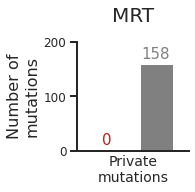

In [686]:
selected_sample=['AU2202']
figsize=(2,2)
ylim=200
x_val1=20
x_val2=20
range_val=100
print(selected_sample)
s = selected_sample[0]
other_sigs = ['SBS1','SBS5','SBS18','SBS40']
df = SBS31_df[SBS31_df.index.isin(selected_sample)]
df['other_sigs'] = df[other_sigs].sum(axis=1)
df = df[['SBS31','other_sigs']]
sigs = df.columns.tolist()
labels = []
title = 'MRT'
xlabel='Private\nmutations'
ylabel='Number of\nmutations'

rotation_xtick=0
rotation_pvals=0

fig, ax = plt.subplots(figsize=figsize)

ax.plot(0, 0, 'o',color='white',markersize=10)

val = df['other_sigs'].tolist()[0]
pos = x +0.2
ax.bar(0.2, val, color='grey',width=0.1,edgecolor='grey')

plt.title(title,size=20,pad=20)
plt.margins(0.22,0)

#y-axis
plt.ylabel(ylabel,size=16)
plt.yticks(np.arange(0, ylim+100, range_val),size=12)
plt.ylim(0,ylim)

#x-axis
plt.xticks([])
plt.xlabel(xlabel,size=14)


plt.text(0.04, x_val1, str(0), color='firebrick', fontweight='normal',ha='center',va='center',size=15)

v = df['other_sigs'][0]
plt.text(0.2, v+x_val2, str(int(round(v,0))), color='grey', fontweight='normal',ha='center',va='center',size=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_linewidth(2) 
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2,length=7)


ax.grid(False)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/'+selected_sample[0]+'_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()

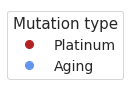

In [590]:
fig, ax = plt.subplots(figsize=(1,1))
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                          markersize=8, label='Platinum')
aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                          markersize=8, label='Aging')
plt.legend(handles=[sbs31,aging],bbox_to_anchor=(1,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/legend_platinumn_vs_aging.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Mutation rates

In [354]:
dates_dict = {'pt3':{'DOB':'24-12-2007',
                     'AU2198':'15-04-2011',
                     'AU2199':'13-11-2008',
                     'AU2200':'20-09-2017',
                    'DTT1':'15-11-2008',
                    'DTT2':'17-03-2009'},
             'pt1':{'DOB':'08-02-2009',
                    'AU2202':'15-03-2019',
                   'AZ4609':'08-08-2019',
                   'AZ4610':'08-08-2019',
                   'AZ4611':'08-08-2019',
                   'AZ4612':'08-08-2019',
                   'AZ4613':'08-08-2019',
                   'AZ4614':'21-02-2019',
                   'DTT1':'03-08-2010',
                   'DTT2':'05-01-2012'},
             'ptX':{'DOB':'10-11-2003',
                   'AZ6342':'05-12-2017'},
             'ptY':{'DOB':'08-10-2015',
                   'AZ6371':'23-01-2017'}}


def calculate_time(row,samples):
    date_dob = row['DOB']
    day_dob = date_dob.split('-')[0]
    month_dob = date_dob.split('-')[1]
    year_dob = date_dob.split('-')[2]
    for sample in samples:
        date_sample = row[sample]
        day_sample = date_sample.split('-')[0]
        month_sample = date_sample.split('-')[1]
        year_sample = date_sample.split('-')[2]
        
        years_diff = int(year_sample) - int(year_dob)
        months_diff = int(month_sample) - int(month_dob)
        days_diff = int(day_sample) - int(day_dob)
        
        all_years_diff = years_diff + (months_diff/12) + ((days_diff/30)/12)
        
        row[sample+'_t'] = all_years_diff
        
    return row

def time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days):
    dates1_df = pd.DataFrame.from_dict(dates_dict[pt],orient='index')
    dates1_df = dates1_df.T


    dates1_df = dates1_df.apply(lambda row: calculate_time(row,selected_samples),axis=1)
    cols = [sample + '_t' for sample in selected_samples]
    df1 = dates1_df[cols]
    df1 = df1.rename(columns={col:col.split('_')[0] for col in cols})
    if time_unit == 'days':        
        for sample in selected_samples:
            df1[sample] = df1[sample].apply(lambda x: x*365)
    
    df1 = df1.T
    if time_unit == 'days':
        df1['time_ttmt'] = ttmt_days
    elif time_unit == 'years':
        ttmt_years = ttmt_days/365
        df1['time_ttmt'] = ttmt_years
        
    df1 = df1.rename(columns={0:'time_birth'})

    return df1

In [408]:
selected_samples = ['AU2198','AU2199','AU2200']
pt='pt3'
time_unit='days'
ttmt_days = 16
df1 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
pt='pt1'
ttmt_days = 8
df2 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6342']
pt='ptX'
ttmt_days = 0
df3 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6371']
pt='ptY'
ttmt_days = 0
df4 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
time_days_dose_adj_df = pd.concat([df1,df2,df3,df4],ignore_index=False)
time_days_dose_adj_df

,time_birth,time_ttmt
AU2198,1207.541667,16
AU2199,323.430556,16
AU2200,3554.694444,16
AU2202,3687.513889,8
AZ4609,3832.500000,8
AZ4610,3832.500000,8
AZ4611,3832.500000,8
AZ4612,3832.500000,8
AZ4613,3832.500000,8
AZ4614,3663.180556,8


In [409]:
selected_samples = ['AU2198','AU2199','AU2200']
pt='pt3'
time_unit='years'
ttmt_days = 16
df1 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
pt='pt1'
ttmt_days = 8
df2 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6342']
pt='ptX'
ttmt_days = 0
df3 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6371']
pt='ptY'
ttmt_days = 0
df4 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
time_years_dose_adj_df = pd.concat([df1,df2,df3,df4],ignore_index=False)
time_years_dose_adj_df

,time_birth,time_ttmt
AU2198,3.308333,0.043836
AU2199,0.886111,0.043836
AU2200,9.738889,0.043836
AU2202,10.102778,0.021918
AZ4609,10.500000,0.021918
AZ4610,10.500000,0.021918
AZ4611,10.500000,0.021918
AZ4612,10.500000,0.021918
AZ4613,10.500000,0.021918
AZ4614,10.036111,0.021918


sbs31 ci:
[1.5080079212143147, 1.2528939767074063, 1.5186802494011187]
[1.3044920787856853, 1.5596060232925937, 1.6063197505988813]
aging ci:
[0.0024645506004695237, 0.0, 0.0038309423235981226]
[0.002504222043676641, 0.0, 0.0037646472332476763]
[-5  0  5 10 15 20 25]
['', '0', '5', '10', '15', '20', '25']


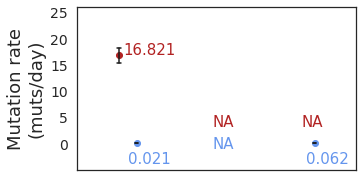

In [266]:
#mutations /day administered
selected_samples = ['AU2198','AU2199','AU2200']
aging_sigs = ['SBS1','SBS5','SBS40']
df = pd.merge(SBS31_df,time_days_dose_adj_df,left_index=True,right_index=True)
df = df[df.index.isin(selected_samples)]
df['aging_sigs'] = df[aging_sigs].sum(axis=1)
df['SBS31_rate'] = df['SBS31'] / df['time_ttmt']
df['aging_rate'] = df['aging_sigs'] / df['time_birth']
sigs = df.columns.tolist()
labels = []
title = ''
ylim=26
xlabel=''
ylabel='Mutation rate\n(muts/day)'
loc=-80
legend=False
figsize = (5,3)
rotation_xtick=0
rotation_pvals=0
ha='center'

ci_low = []
ci_high = []
for s in selected_samples:
    cl = (df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0]) / df['time_ttmt'][df.index==s].iloc[0]
    ch = (ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0]) / df['time_ttmt'][df.index==s].iloc[0]
    ci_low.append(cl)
    ci_high.append(ch)

print('sbs31 ci:')
print(ci_low)
print(ci_high)

horizontal_line_width = 0.04
plt.figure(figsize=figsize)
for x,val in enumerate(df['SBS31_rate'].tolist()):
    if x in [1,2]:
        pass
    else:
        pos = x
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='firebrick')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
    
ci_low = []
ci_high = []
for s in selected_samples:
    cl = (df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0]) / df['time_birth'][df.index==s].iloc[0]
    ch = (ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0]) / df['time_birth'][df.index==s].iloc[0]
    ci_low.append(cl)
    ci_high.append(ch)
print('aging ci:')
print(ci_low)
print(ci_high)

for x,val in enumerate(df['aging_rate'].tolist()):
    if x in [1]:
        pass
    else:   
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='cornflowerblue')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

plt.title(title,size=20,pad=20)
plt.margins(0.2,0)

#y-axis
plt.ylabel(ylabel)
plt.ylim(0,ylim)

#x-axis
plt.xlabel(xlabel)
ticks = range(0,len(df))
plt.xticks(ticks,[])
yticks = np.arange(-5, ylim, 5)
print(yticks)
yticklabels = [str('') if tick == -5 else str(tick) for tick in yticks ]
print(yticklabels)
plt.yticks(ticks = yticks,labels= yticklabels,size=14)

for i, v in enumerate(df['SBS31_rate']):
    if i in [1,2]:
        plt.text(i+0.05, v+2, 'NA', color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    else:
        plt.text(i+0.05, v+1, str(round(v,3)), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
for i, v in enumerate(df['aging_rate']):
    if i in [1]:
        plt.text(i+0.05, v, 'NA', color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)
    else:
        plt.text(i+0.1, v-3, str(round(v,3)), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)
ax.grid(False)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/pt1_mut_rate.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


In [382]:
#mutations /day administered
def small_plot_mut_rate (selected_sample,figsize=(1,2),ylim=26,yticks = np.arange(-5, ylim, 5)):
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = pd.merge(SBS31_df,time_days_dose_adj_df,left_index=True,right_index=True)
    df = df[df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df['SBS31_rate'] = df['SBS31'] / df['time_ttmt']
    df['aging_rate'] = df['aging_sigs'] / df['time_birth']
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Mutation rate\n(muts/day)'
    loc=-80
    legend=False
    rotation_xtick=0
    rotation_pvals=0
    ha='center'
    
    ci_low = []
    ci_high = []
    
    s = selected_sample[0]
    
    horizontal_line_width = 0.04
    fig,ax = plt.subplots(figsize=figsize)
    
    if s in ['AZ6342','AZ6371']:
        pass
    else:
        cl = (df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0]) / df['time_ttmt'][df.index==s].iloc[0]
        ch = (ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0]) / df['time_ttmt'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['SBS31_rate'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, 'o',color='white',markersize=10)
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.plot(pos, val, 'o',color='firebrick',markersize=10)
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = []
    ci_high = []
    for s in selected_sample:
        cl = (df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0]) / df['time_birth'][df.index==s].iloc[0]
        ch = (ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0]) / df['time_birth'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['aging_rate'].tolist()):   
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.plot(pos, val, 'o',color='cornflowerblue',markersize=10)
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    plt.title(title,size=20,pad=20)
    plt.margins(0.2,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
    yticklabels = [str('') if tick == -5 else str(tick) for tick in yticks ]
    plt.yticks(ticks = yticks,labels= yticklabels,size=14)

    for i, v in enumerate(df['SBS31_rate']):
        if selected_sample[0] in  ['AZ6342','AZ6371']:
            pass
        else:
            plt.text(i+0.05, v+1, str(round(v,3)), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    for i, v in enumerate(df['aging_rate']):
        plt.text(i+0.25, v, str(round(v,3)), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)
    
    ax.grid(False)
    plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/'+selected_sample[0]+'_mut_rate.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


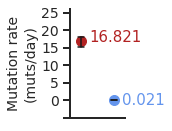

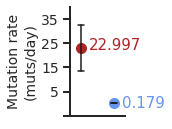

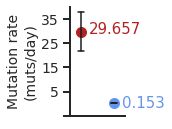

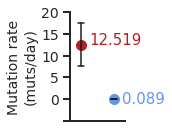

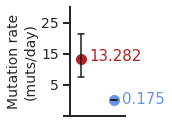

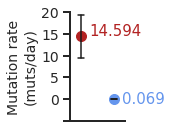

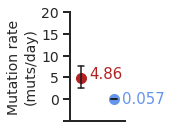

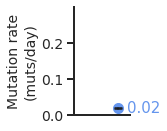

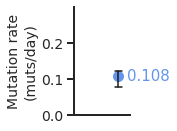

In [411]:
selected_sample = ['AU2198']
small_plot_mut_rate(selected_sample)
selected_sample = ['AZ4609']
small_plot_mut_rate(selected_sample,ylim=40,yticks = np.arange(-5, 41, 10))
selected_sample = ['AZ4610']
small_plot_mut_rate(selected_sample,ylim=40,yticks = np.arange(-5, 41, 10))
selected_sample = ['AZ4611']
small_plot_mut_rate(selected_sample,ylim=20,yticks = np.arange(-5, 21, 5))
selected_sample = ['AZ4612']
small_plot_mut_rate(selected_sample,ylim=30,yticks = np.arange(-5, 31, 10))
selected_sample = ['AZ4613']
small_plot_mut_rate(selected_sample,ylim=20,yticks = np.arange(-5, 21, 5))
selected_sample = ['AZ4614']
small_plot_mut_rate(selected_sample,ylim=20,yticks = np.arange(-5, 21, 5))
selected_sample = ['AZ6342']
small_plot_mut_rate(selected_sample,ylim=0.30,yticks = np.arange(0, 0.30, 0.1))
selected_sample = ['AZ6371']
small_plot_mut_rate(selected_sample,ylim=0.30,yticks = np.arange(0, 0.30, 0.1))

In [566]:
#mutations /day administered
def small_barplot_mut_rate (selected_sample,figsize=(1,2),ylim=26,yticks = np.arange(-5, ylim, 5), x_val1=1, x_val2=1,log_scale=False):
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = pd.merge(SBS31_df,time_days_dose_adj_df,left_index=True,right_index=True)
    df = df[df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df['SBS31_rate'] = df['SBS31'] / df['time_ttmt']
    df['aging_rate'] = df['aging_sigs'] / df['time_birth']
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Mutation rate\n(muts/day)'
    loc=-80
    legend=False
    rotation_xtick=0
    rotation_pvals=0
    ha='center'
    
    ci_low = []
    ci_high = []
    
    s = selected_sample[0]
    
    horizontal_line_width = 0.04
    fig,ax = plt.subplots(figsize=figsize)
    
    if s in ['AZ6342','AZ6371']:
        pass
    else:
        cl = (df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0]) / df['time_ttmt'][df.index==s].iloc[0]
        ch = (ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0]) / df['time_ttmt'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['SBS31_rate'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, color='white')
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.bar(pos, val, color='firebrick',width=0.1,edgecolor='firebrick')
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = []
    ci_high = []
    for s in selected_sample:
        cl = (df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0]) / df['time_birth'][df.index==s].iloc[0]
        ch = (ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0]) / df['time_birth'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['aging_rate'].tolist()):   
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.bar(pos, val, color='cornflowerblue',width=0.1,edgecolor='cornflowerblue')
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    plt.title(title,size=20,pad=20)
    plt.margins(0.2,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
#     yticklabels = [str('') if tick == -5 else str(tick) for tick in yticks ]
#     plt.yticks(ticks = yticks,labels= yticklabels,size=14)
    if log_scale==True:
        plt.yscale('log')

    for i, v in enumerate(df['SBS31_rate']):
        if selected_sample[0] in  ['AZ6342','AZ6371']:
            pass
        else:
            plt.text(i+0.1, v+x_val1, str(round(v,2)), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
    for i, v in enumerate(df['aging_rate']):
        plt.text(i+0.25, v+x_val2, str(round(v,2)), color='cornflowerblue', fontweight='normal',ha='center',va='center',size=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)
    
    ax.grid(False)
    plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/'+selected_sample[0]+'_mut_rate.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


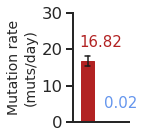

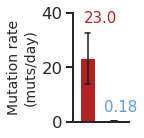

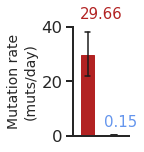

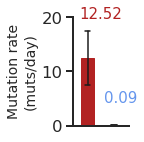

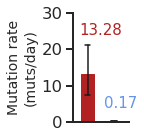

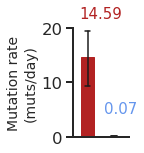

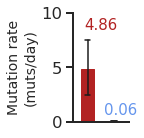

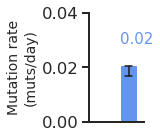

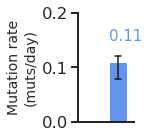

In [572]:
selected_sample = ['AU2198']
small_barplot_mut_rate(selected_sample,ylim=30,yticks = np.arange(0, 31, 10),x_val1=5,x_val2=5)
selected_sample = ['AZ4609']
small_barplot_mut_rate(selected_sample,ylim=40,yticks = np.arange(0, 41, 10),x_val1=15,x_val2=5)
selected_sample = ['AZ4610']
small_barplot_mut_rate(selected_sample,ylim=40,yticks = np.arange(0, 41, 10),x_val1=15,x_val2=5)
selected_sample = ['AZ4611']
small_barplot_mut_rate(selected_sample,ylim=20,yticks = np.arange(0, 21, 5),x_val1=8,x_val2=5)
selected_sample = ['AZ4612']
small_barplot_mut_rate(selected_sample,ylim=30,yticks = np.arange(0, 31, 10),x_val1=12,x_val2=5)
selected_sample = ['AZ4613']
small_barplot_mut_rate(selected_sample,ylim=20,yticks = np.arange(0, 21, 5),x_val1=8,x_val2=5)
selected_sample = ['AZ4614']
small_barplot_mut_rate(selected_sample,ylim=10,yticks = np.arange(0, 11, 5),x_val1=4,x_val2=1)
selected_sample = ['AZ6342']
small_barplot_mut_rate(selected_sample,ylim=0.04,yticks = np.arange(0, 0.3, 0.01),x_val2=0.01)
selected_sample = ['AZ6371']
small_barplot_mut_rate(selected_sample,ylim=0.2,yticks = np.arange(0, 0.3, 0.1),x_val2=0.05)

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.0

sbs31 ci:
[-5.0, 73.97867402220001, 62.25298159736198, 40.151214602037996, 46.25392848355, 41.749279561444, 18.877121515443605]
[45.0, 76.02132597779999, 67.74701840263802, 39.848785397962004, 63.74607151645, 38.250720438556, 21.122878484556395]
aging ci:
[19.374668136089298, 56.19064051671796, 55.47083387395196, 33.693838538384966, 63.746071516450456, 35.81071011242602, 15.395295711818989]
[9.625331863910702, 54.80935948328204, 52.52916612604804, 33.306161461615034, 46.253928483549544, 39.18928988757398, 13.604704288181011]


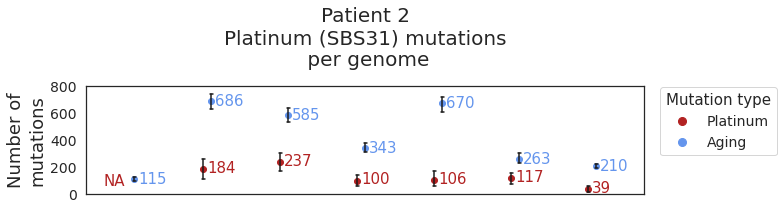

In [211]:
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
aging_sigs = ['SBS1','SBS5','SBS40']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df['aging_sigs'] = df[aging_sigs].sum(axis=1)
df = df[['SBS31','aging_sigs']]
df[['SBS31'][0]][0] = 0
display(df[['SBS31'][0]][0])
df = pd.DataFrame(df)
sigs = df.columns.tolist()
labels = []
title = 'Patient 2\nPlatinum (SBS31) mutations\n per genome'
ylim=600
xlabel=''
ylabel='Number of\nmutations'
loc=-80
legend=False
figsize = (10,2)
rotation_xtick=0
rotation_pvals=0
ha='center'

ci_low = [ df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0] for s in selected_samples]
ci_high = [ ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0] for s in selected_samples]
print('sbs31 ci:')
print(ci_low)
print(ci_high)

horizontal_line_width = 0.04
plt.figure(figsize=figsize)
for x,val in enumerate(df['SBS31'].tolist()):
    if x in [0]:
        pass
    else:
        pos = x+0.1
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='firebrick')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
    
ci_low = [ df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0] for s in selected_samples]
ci_high = [ ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0] for s in selected_samples]
print('aging ci:')
print(ci_low)
print(ci_high)

for x,val in enumerate(df['aging_sigs'].tolist()):
    pos = x +0.2
    left = pos - horizontal_line_width / 2
    top = val + ci_high[x]
    right = pos + horizontal_line_width / 2
    bottom = val - ci_low[x]
    plt.plot(pos, val, 'o',color='cornflowerblue')
    plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
    plt.plot([left, right], [top, top], color='k',linewidth=1.5)
    plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
#df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
plt.title(title,size=20,pad=20)
plt.margins(0.1,0)

if legend == True:
    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 14})

#y-axis
plt.ylabel(ylabel)
plt.ylim(0,ylim)

#x-axis
plt.xlabel(xlabel)
ticks = range(0,len(df))
plt.xticks(ticks,[])
plt.yticks(np.arange(0, ylim+400, 200),size=14)
        
for i, v in enumerate(df['SBS31']):
    if i in [0]:
        plt.text(-0.2, 100, 'NA', color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    else:
        plt.text(i+0.15, v+10, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
for i, v in enumerate(df['aging_sigs']):
    plt.text(i+0.25, v-0, str(int(round(v,0))), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)

sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                          markersize=8, label='Platinum')
aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                          markersize=8, label='Aging')
plt.legend(handles=[sbs31,aging],bbox_to_anchor=(0.25,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)
ax.grid(False)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/pt2_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


sbs31 ci:
[-0.625, 9.247334252775001, 7.781622699670248, 5.0189018252547495, 5.78174106044375, 5.2186599451805, 2.3596401894304506]
[5.625, 9.502665747224999, 8.468377300329752, 4.9810981747452505, 7.96825893955625, 4.7813400548195, 2.6403598105695494]
aging ci:
[0.0052541275015854155, 0.014661615268550024, 0.014473798792942456, 0.00879160822919373, 0.0166330258359949, 0.00934395567186589, 0.004202712773322239]
[0.0026102496570693536, 0.014301202735363871, 0.013706240346000794, 0.008690453088484026, 0.012068865879595445, 0.010225515952400255, 0.003713904920014987]
[-10   0  10  20  30  40]
['', '0', '10', '20', '30', '40']


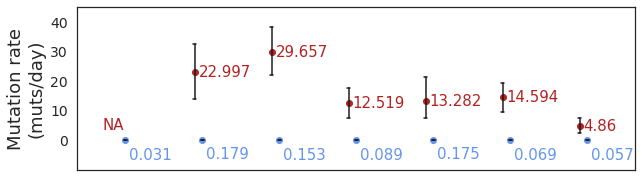

In [216]:
#mutation/day 50mg/day adjusted
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
aging_sigs = ['SBS1','SBS5','SBS40']
df = pd.merge(SBS31_df,time_days_dose_adj_df,left_index=True,right_index=True)
df = df[df.index.isin(selected_samples)]
df['aging_sigs'] = df[aging_sigs].sum(axis=1)
df[['SBS31'][0]][0] = 0
df['SBS31_rate'] = df['SBS31'] / df['time_ttmt']
df['aging_rate'] = df['aging_sigs'] / df['time_birth']
df = pd.DataFrame(df)
sigs = df.columns.tolist()
labels = []
title = ''
ylim=45
xlabel=''
ylabel='Mutation rate\n(muts/day)'
loc=-80
legend=False
figsize = (10,3)
rotation_xtick=0
rotation_pvals=0
ha='center'

ci_low = []
ci_high = []
for s in selected_samples:
    cl = (df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0]) / df['time_ttmt'][df.index==s].iloc[0]
    ch = (ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0]) / df['time_ttmt'][df.index==s].iloc[0]
    ci_low.append(cl)
    ci_high.append(ch)
print('sbs31 ci:')
print(ci_low)
print(ci_high)

horizontal_line_width = 0.04
plt.figure(figsize=figsize)
for x,val in enumerate(df['SBS31_rate'].tolist()):
    if val != 0:
        pos = x+0.1
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        plt.plot(pos, val, 'o',color='firebrick')
        plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        plt.plot([left, right], [top, top], color='k',linewidth=1.5)
        plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
    
ci_low = []
ci_high = []
for s in selected_samples:
    cl = (df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0]) / df['time_birth'][df.index==s].iloc[0]
    ch = (ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0]) / df['time_birth'][df.index==s].iloc[0]
    ci_low.append(cl)
    ci_high.append(ch)
print('aging ci:')
print(ci_low)
print(ci_high)

for x,val in enumerate(df['aging_rate'].tolist()):
    pos = x +0.2
    left = pos - horizontal_line_width / 2
    top = val + ci_high[x]
    right = pos + horizontal_line_width / 2
    bottom = val - ci_low[x]
    plt.plot(pos, val, 'o',color='cornflowerblue')
    plt.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
    plt.plot([left, right], [top, top], color='k',linewidth=1.5)
    plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
#df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
plt.title(title,size=20,pad=20)
plt.margins(0.1,0)

if legend == True:
    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 14})

#y-axis
plt.ylabel(ylabel)
plt.ylim(0,ylim)

#x-axis
plt.xlabel(xlabel)
ticks = range(0,len(df))
plt.xticks(ticks,[])
yticks = np.arange(-10, ylim, 10)
print(yticks)
yticklabels = [str('') if tick == -10 else str(tick) for tick in yticks ]
print(yticklabels)
plt.yticks(ticks = yticks,labels= yticklabels,size=14)
        
for i, v in enumerate(df['SBS31_rate']):
    if v == 0:
        plt.text(-0.1, 5, 'NA', color='firebrick', fontweight='normal',ha='left',va='center',size=15)
    else:
        plt.text(i+0.15, v, str(round(v,3)), color='firebrick', fontweight='normal',ha='left',va='center',size=15)
for i, v in enumerate(df['aging_rate']):
    plt.text(i+0.25, v-5, str(round(v,3)), color='cornflowerblue', fontweight='normal',ha='left',va='center',size=15)

ax.grid(False)
plt.savefig('/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/pt2_mut_rate.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


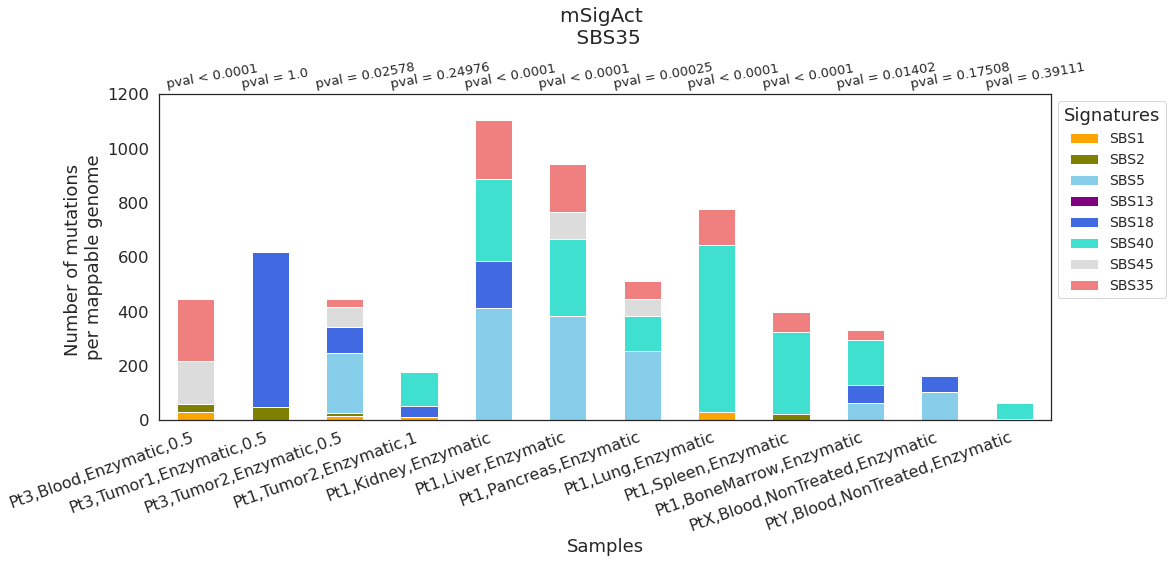

In [117]:
df = SBS35_df
sigs = df.columns.tolist()
labels = [item[1] for item in sample_name_dict.items() if item[0] in SBS35_df.index]
pvals = [item[1] for item in SBS35_pvals.items() if item[0] in SBS35_df.index]
title = 'mSigAct \n SBS35'
ylim=1200
xlabel='Samples'
ylabel='Number of mutations \nper mappable genome'
loc=-80
legend=True
figsize = (16,6)
plot_fitting_with_pval2(df,title,sigs,labels,ylim,legend,loc,pvals,xlabel,figsize,ylabel,rotation_pvals=10,rotation_xtick=20,ha='right')


In [64]:
SBS35_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS35
sample_id,,,,,,,,
AU2198,29.546339,30.297189,0.000000,0.0,0.000000,0.000000,158.948034,229.208438
AU2199,0.000000,50.648423,0.000000,0.0,568.351577,0.000000,0.000000,0.000000
AU2200,14.696604,13.019748,219.190749,0.0,94.661166,0.000000,75.264806,30.166926
AU2202,12.912159,0.000000,0.000000,0.0,40.803173,123.284668,0.000000,0.000000
AZ4609,0.000000,0.000000,412.600284,0.0,171.709362,303.632135,0.000000,218.058220
AZ4610,0.000000,0.000000,382.549256,0.0,0.000000,285.219675,97.098693,177.132376
AZ4611,0.000000,0.000000,255.214094,0.0,0.000000,127.980731,64.417401,65.387774
AZ4612,28.887461,0.000000,0.000000,0.0,0.000000,616.392750,0.000000,130.719789
AZ4613,0.000000,24.780861,0.000000,0.0,0.000000,300.400871,0.000000,72.818268
